# Pycle demo 1: efficient sketch tuning for GMM fitting
This notebook demonstrates the following features of the `pycle`toolbox: tuning the (frequency sampling pattern of the) sketch from a light "pre-sketch" on a small subset of the dataset, and learning and plotting a GMM distribution. In particular, we will:
0. Generate a synthetic dataset
1. Sketch a small subset of it with a data-independent distribution, and use it to learn the actual frequency sampling pattern we will use to sketch the whole dataset.
2. Learn a Gaussian mixture model from this adapted sketch.

We assume that you have installed `pycle` with `pip` or that you have the `pycle` folder in the same directory as this notebook.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
np.random.seed(42)

To demonstrate the toolbox, we generate a simple synthetic dataset, from a Gaussian mixture model in two dimensions.

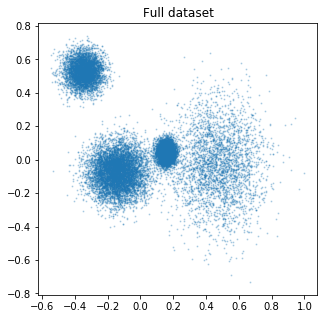

In [2]:
from pycle.utils import generatedataset_GMM

d = 2     # Dimension
K = 4     # Number of Gaussians
n = 20000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle, where we ask that
# - All entries are bounded by 1 (normalize='l_inf-unit-ball')
# - We get at the output the "ground-truth" GMM that was used to generate the dataset (output_required='GMM')
# - The clusters are imbalanced ('balanced=0.1')
# - That cluster scales vary moderately ('covariance_variability_inter = 1.5')
(X,GT_GMM) = generatedataset_GMM(d,K,n,normalize='l_inf-unit-ball',output_required='GMM',balanced=0.1,covariance_variability_inter = 1.5) 

# Visualize the dataset
plt.figure(figsize=(5,5))
plt.title("Full dataset")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.25)
plt.show()

In this example, we want to use a random Fourier features sketch, but we don't know beforehand how to draw the frequencies associated with those features (we don't know the associated $\Sigma$ parameter). We thus allow ourselves to oberse a small subset of the dataset ($n_0$ samples, which here correspond to $2\%$ of the obervations) through a smaller, arbitrarily generated "pre-sketch" of size $m_0$. (Without entering into the details[1], know that this is done by iteratively selecting $m_0$ candidate values for $\boldsymbol \omega_j$ according to an arbitrary initial guess for $\Sigma$, compute the associated sketch, then updating $\Sigma$ by fitting a Gaussian curve to the maximal absolute values of the sketch in $c$ contiguous blocks when ordered as a function of $\|\boldsymbol \omega_j\|$.)

All this is implemented by the `sk.estimate_Sigma` method.

[1] See section 3.3.3 of https://arxiv.org/pdf/1606.02838.pdf.

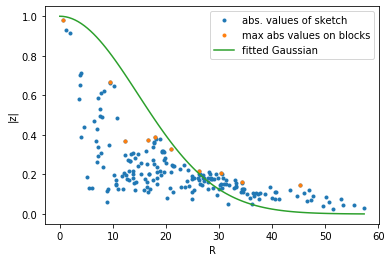

Estimated sigma2_bar:  0.004619715665302314


In [3]:
import pycle.sketching as sk # import sketching submodule

m0 = 200    # use a pre-sketch of size 100
n0 = n//50  # observe 2% of the dataset to estimata Sigma

Sigma = sk.estimate_Sigma(X,m0,c=10,n0=n0,verbose=1)
print("Estimated sigma2_bar: ",Sigma[0][0])

By putting `verbose=1`, we asked `estimate_Sigma` to plot the fit to the pre-sketch amplitudes.
After this, we can generate the sketch and compress the whole dataset.

In [4]:
m = 20*K*d
Omega = sk.drawFrequencies("FoldedGaussian",d,m,Sigma)

Phi = sk.SimpleFeatureMap("ComplexExponential",Omega)

z = sk.computeSketch(X,Phi)

Let's use this sketch to learn a Gaussian mixture model. Note since `CLOMPR_GMM` is sensible to spurious local optima, we ask it to run 5 independent trials and keep the one that that achieves the lowest the objective function (`bestOfRuns=5`).

In [5]:
import pycle.compressive_learning as cl

CGMM = cl.CLOMPR_GMM(z,Phi,K,bestOfRuns=5)

print("weights: \n",CGMM[0])
print("centers: \n",CGMM[1])
print("covariances: \n",CGMM[2])

weights: 
 [0.27158613 0.22783208 0.34531714 0.15526465]
centers: 
 [[ 0.15555358  0.04222712]
 [-0.34470418  0.52775715]
 [-0.14148807 -0.07451255]
 [ 0.46412496 -0.02627793]]
covariances: 
 [[[0.00075083 0.        ]
  [0.         0.00148747]]

 [[0.00339421 0.        ]
  [0.         0.00400968]]

 [[0.00785682 0.        ]
  [0.         0.0084808 ]]

 [[0.02114743 0.        ]
  [0.         0.03643636]]]


The returned `CGMM` is a tuple containing the weights, centers and covariances of the fitted Gaussians. We can plot the learned model with the `plotGMM` method of the `pycle.utils` submodule. We also evaluate the quality of the model through the log-likelihood and the (symmetric) Kullback-Leibler divergence.

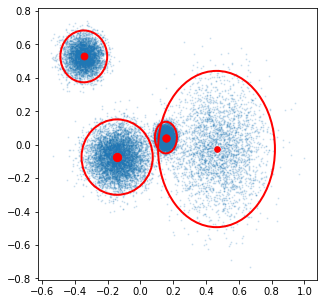

Log-likelihood:          1.1911472085412727
LL of the ground truth:  1.1911728845983365
Kullback-Leibler divergence:  0.0011167235947624


In [6]:
from pycle.utils import plotGMM, loglikelihood_GMM, symmKLdivergence_GMM
plotGMM(X,CGMM)
print("Log-likelihood:         ",loglikelihood_GMM(CGMM,X,robust = False))
print("LL of the ground truth: ", loglikelihood_GMM(GT_GMM,X,robust = False))
print("Kullback-Leibler divergence: ",symmKLdivergence_GMM(CGMM,GT_GMM))